# Whole space decomposition

The single column decomposition works only for an initial state in a particular eigenspace of the Hamiltonian, (see decomposition.ipynb). If the initial state is a generic sovrapposition we need to find a new decomposition.

Here we describe our best decomposition for any initial state, that has 11 c-not (14 with the jakarta geometry). 

# 1) Idea explanation

Like in the Single Column Decomposition we want to numerically calculate a single Trotter Step Operator and find an optimal circuit for $T_{step}^{n}$. 

In [26]:
from lib.functions0 import *
from sympy import *

parameter = Symbol("alpha", real=True)
time = np.pi
n_steps = 100

Trotter_Step_Matrix = trotter_step_matrix(time, n_steps)
Trotter_Step_Matrix

array([[ 9.98026728e-01-6.27905195e-02j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  9.98026728e-01-1.14187328e-18j,
         5.44840444e-19-6.27905195e-02j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  3.93486942e-03-6.25429585e-02j,
         9.94091859e-01+6.25429585e-02j,  0.00000000e+00+0.00000000e+00j,
         5.44840444e-19-6.27905195e-02j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

The idea is to find a basis change where the Trotter_Step_Matrix is in the form:

$
T_{step} = M \otimes Id_{2x2}
$

Where M is a 2 Qubit Gate.

In [39]:
from sympy.physics.quantum import TensorProduct as Tp

B = Matrix([
    [0,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,1]
])
latex(B)

'\\left[\\begin{matrix}0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\\\1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\\\0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\\\0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\end{matrix}\\right]'

In [28]:
B*Trotter_Step_Matrix*B.H

Matrix([
[ 0.998026728428271 + 4.72478947392371e-18*I,  0.00393486942489572 - 0.0625429585287595*I, -0.00393486942489572 - 0.000247561000553874*I,                                        0,                                           0,                                           0,                                             0,                                        0],
[5.44840444062603e-19 - 0.0627905195293134*I,    0.994091859003376 + 0.0625429585287595*I,    0.00393486942489572 - 0.0625429585287595*I,                                        0,                                           0,                                           0,                                             0,                                        0],
[                                          0, 5.44840444062603e-19 - 0.0627905195293134*I,    0.998026728428271 - 1.14187328118397e-18*I,                                        0,                                           0,                                           0,  

As we can see in the B basis the Trotter steps can be reduced to a 2 Qubit gate.

Now we can change tha base before the evolution and apply N trotter steps in the new base:

$
B \cdot T_{step}^N \cdot B^{+} =( B \cdot T_{step} \cdot B^{+})\cdot (  B \cdot T_{step} \cdot B^{+}) \cdot ... \cdot (B \cdot T_{step} \cdot B^{+}) = (M \otimes Id_{2x2})^N
$

To optimize the circuit instead of changing the base with the B gate we prepare the initial state already in the new base (this is easy because B is just a permutation matrix):

$
|\psi>_{prepared} = B^{+} \cdot |\psi>_{init} 
$

So finally we have:

$
T_{step}^N |\psi>_{init} =  B \cdot B^{+} \cdot T_{step}^N \cdot B \cdot B^{+} |\psi>_{init} = B \cdot( B^{+} \cdot T_{step}^N \cdot B) |\psi>_{prepared} = 
$

$
=  B \cdot (M \otimes Id_{2x2})^N |\psi>_{prepared} = B \cdot (M^N \otimes Id_{2x2}) |\psi>_{prepared}
$

Now we need to find a minimal decomposition for B and $M^{n}$.


# 2) Matrices Decomposition

## 2.1) B matrix

B is a permutation matrix so is possible to implement it just using x, c-x and toffoli gates (because they correspond to make columns and rows moves).


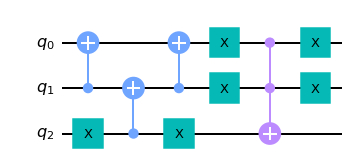

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

qr=QuantumRegister(3, name="q")
B_qc=QuantumCircuit(qr, name="B")
B_qc.x(qr[2])
B_qc.cx(qr[1],qr[0])
B_qc.cx(qr[2],qr[1])
B_qc.cx(qr[1],qr[0])
B_qc.x([qr[0],qr[1],qr[2]])
B_qc.toffoli(qr[0],qr[1],qr[2])#append(Toffoli_gate,[qr[0],qr[1],qr[2]])
B_qc.x([qr[0],qr[1]])

B_qc.draw(output="mpl")

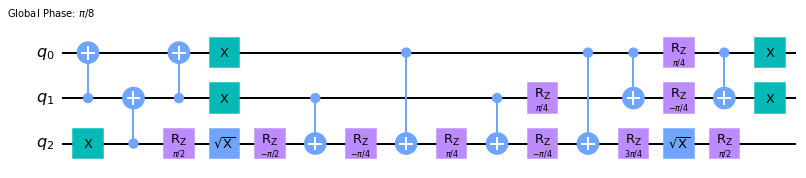

In [30]:
transpile(B_qc, basis_gates=["cx", "x", "rz", "sx"]).draw(output="mpl")

Where the best decomposition for the toffoli gate in jakarta geometry is (8 c-not):

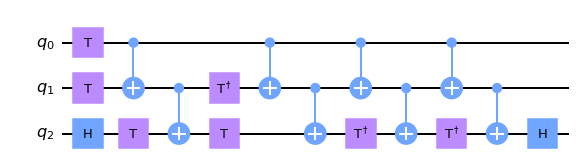

In [31]:
Toffoli_gate.draw(output="mpl")

## 2.1) $M^N$ matrix

The M matrix is the following:

In [32]:
M = B*Trotter_Step_Matrix*B.H
M = Matrix([M[0:4],M[8:12],M[16:20],M[24:28]])
M

Matrix([
[ 0.998026728428271 + 4.72478947392371e-18*I,  0.00393486942489572 - 0.0625429585287595*I, -0.00393486942489572 - 0.000247561000553874*I,                                        0],
[5.44840444062603e-19 - 0.0627905195293134*I,    0.994091859003376 + 0.0625429585287595*I,    0.00393486942489572 - 0.0625429585287595*I,                                        0],
[                                          0, 5.44840444062603e-19 - 0.0627905195293134*I,    0.998026728428271 - 1.14187328118397e-18*I,                                        0],
[                                          0,                                           0,                                             0, 0.998026728428271 - 0.0627905195293134*I]])

We compute numerically $M^{n}$.

In [33]:
n_steps = 42
time = np.pi
precision = 40

numeric_evolution_matrix=eye(8)

for _ in range(n_steps): # here is computed the evolution operator numerically, with n_steps trotter steps.
    numeric_evolution_matrix=(numeric_evolution_matrix*trotter_step_matrix(time, n_steps)).evalf(precision)

M_N = B*numeric_evolution_matrix*B.H
M_N = Matrix([M_N[0:4],M_N[8:12],M_N[16:20],M_N[24:28]])
M_N.evalf(5)

Matrix([
[   0.9999 + 0.0058176*I, -0.0012637 + 0.0058176*I,   0.0013669 - 0.011635*I,                  0],
[0.0013669 + 0.0058176*I,      0.9999 - 0.011635*I, -0.0012637 + 0.0058176*I,                  0],
[-0.0012637 - 0.011635*I,  0.0013669 + 0.0058176*I,     0.9999 + 0.0058176*I,                  0],
[                      0,                        0,                        0, 1.0 + 1.1891e-15*I]])

then using transpile we get the best decomposition

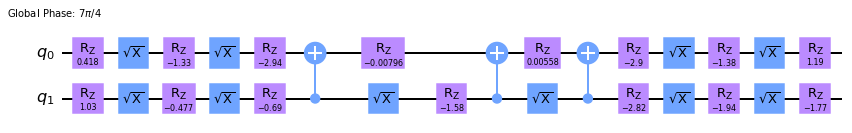

In [34]:
qc=QuantumCircuit(2, name="$M^N$")
qc.unitary(M_N,[0,1])    
M_N_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

M_N_qc.draw(output="mpl")

So now we can built the final circuit in term of 14 cnots

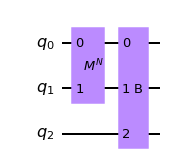

In [35]:
initial_state="000"

qr = QuantumRegister(3, name="q")
qc = QuantumCircuit(qr, name="evo")

### preparing the initial state

l=0
for k in [2,1,0]:
    if initial_state[l]=='1':
        qc.x(qr[k])
    l+=1

### appending the evolution

qc.append(M_N_qc,[qr[0],qr[1]])
qc.append(B_qc,[qr[0],qr[1],qr[2]])

qc.draw(output="mpl")

ora faccio una verifica ma possiamo anche non metterla

In [36]:
def matrix_from_cirquit(qc, phase=0):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    return Matrix(A)


In [37]:
DDDD = matrix_from_cirquit(qc)
DDDD

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Matrix([
[                             0,                              0,                              0,   0,  0.9998967287 + 0.0058175983*I, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0],
[-0.0012636571 - 0.0116351967*I,  0.0013669285 + 0.0058175983*I,  0.9998967287 + 0.0058175983*I,   0,                              0,                              0,                              0,   0],
[ 0.0013669285 + 0.0058175983*I,  0.9998967287 - 0.0116351967*I, -0.0012636571 + 0.0058175983*I,   0,                              0,                              0,                              0,   0],
[ 0.9998967287 + 0.0058175983*I, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0,                              0,                              0,                              0,   0],
[                             0,                              0,                              0, 1.0,                              0,                              0,          

In [38]:
DDDD*B.H

Matrix([
[ 0.9998967287 + 0.0058175983*I,                              0,                              0,                              0,   0, -0.0012636571 + 0.0058175983*I,  0.0013669285 - 0.0116351967*I,   0],
[                             0,  0.9998967287 + 0.0058175983*I,  0.0013669285 + 0.0058175983*I, -0.0012636571 - 0.0116351967*I,   0,                              0,                              0,   0],
[                             0, -0.0012636571 + 0.0058175983*I,  0.9998967287 - 0.0116351967*I,  0.0013669285 + 0.0058175983*I,   0,                              0,                              0,   0],
[                             0,  0.0013669285 - 0.0116351967*I, -0.0012636571 + 0.0058175983*I,  0.9998967287 + 0.0058175983*I,   0,                              0,                              0,   0],
[                             0,                              0,                              0,                              0, 1.0,                              0,          